In [1]:
using Distributed

addprocs(4)

println(workers())

      From worker 5:	 Activating environment at `~/WorkSpace/NodaLab/Scripts/Conduction/Project.toml`


 Activating environment at `~/WorkSpace/NodaLab/Scripts/Conduction/Project.toml`


      From worker 4:	 Activating environment at `~/WorkSpace/NodaLab/Scripts/Conduction/Project.toml`
      From worker 2:	 Activating environment at `~/WorkSpace/NodaLab/Scripts/Conduction/Project.toml`
      From worker 3:	 Activating environment at `~/WorkSpace/NodaLab/Scripts/Conduction/Project.toml`
[2, 3, 4, 5]


**Please be very careful launching this cell only one time!**. If you happen to launch it multiple times, please reload your kernel.

In [2]:
@everywhere begin
    include("../src/Conduction.jl");
    using Plots, VegaLite, LaTeXStrings, QuadGK;
end

We define the global variables plus some function to speed up the computation of the einstein ratio. The computation will be performed on a reduced energy interval: -10 to 10.

In [3]:
@everywhere begin
    range = -10.:0.5:10.;

    semiconductor = Conduction.Semiconductor(
    1.38 * 10^-23, # Boltzman constant (J.K^-1)
    1.6*10^-19, # Electron's charge (C)
    10^7, # decay constant of the assumed hydrogen-like localized state wave functions (cm^-1)
    0.1 * 1.6*10^-19, # Mode effect of the phonons (J)
    2.1 * 10^18, # intrinsic semiconductor's density (cm^-3)
    2.1 * 10^18, # Doping states' density (cm^-3)
    0.1 * 1.6 * 10^-19, # Energy to a vacant target site (J)
    -2*10^5, # Field (V.cm^-1)
    10^13, # Base electron jump rate
    -10.0, # Fermi level (J)
    2.7, # Intrinsic semiconductor's gaussian width (J)
    2.7 # Doping states' gaussian width (J)
    );

    function einsteinRelation(semiconductor, U, T)
        r = Conduction.RnnVRH(semiconductor, U, T)
        x = Conduction.xf(semiconductor, r, U, T)
        t = Conduction.t(semiconductor, r, U, T)
        return Conduction.D(semiconductor, r, x, t) / Conduction.electronMobility(
            semiconductor, r, x)
    end;

    function einsteinRelation_no_t(semiconductor, U, T)
        r = Conduction.RnnVRH(semiconductor, U, T)
        x = Conduction.xf(semiconductor, r, U, T)
        return Conduction.D_no_t(semiconductor, r) / Conduction.electronMobility(
            semiconductor, r, x)
    end;

    function criteria_D(semiconductor, U, T)
        r = Conduction.RnnVRH(semiconductor, U, T)
        return semiconductor.nu * exp(-r) * Conduction.t(semiconductor, r, U, T)
    end;
end;

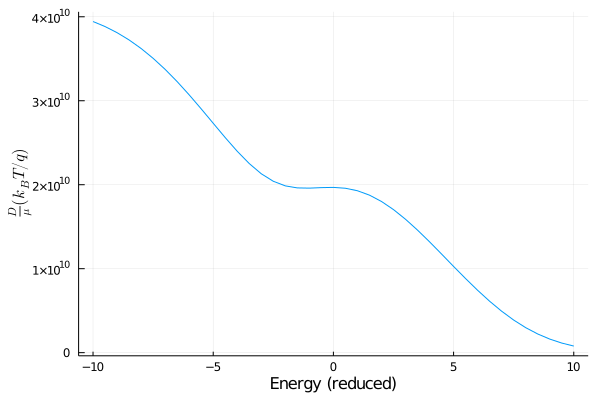

In [4]:
res = pmap(x -> einsteinRelation(semiconductor, x, 300.), range);
plot(range, res * semiconductor.k * 300 / semiconductor.q,
xlabel="Energy (reduced)", ylabel=L"\dfrac{D}{\mu} (k_B T / q)", label="")

We see here that the numerical values seem to be too high. We will plot the following criteria $\bar \nu t$. It should always be well below 1.

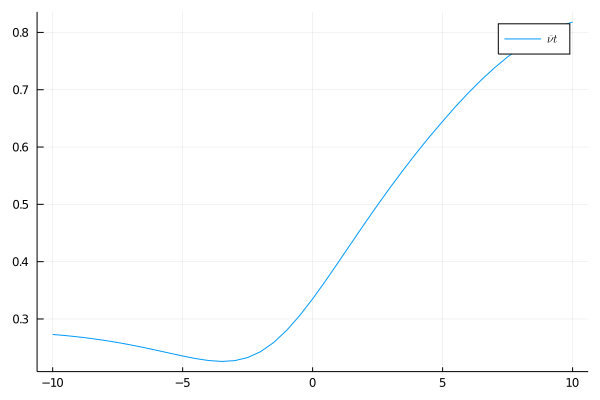

In [5]:
criteria = pmap(x -> criteria_D(semiconductor, x, 300), range);
plot(range, criteria, label=L"\bar \nu t")

We see on the above figure that the criteria does not seem to be respected.

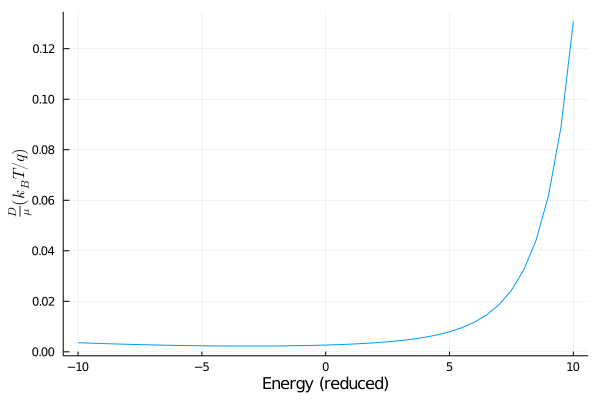

In [6]:
res_no_t = pmap(x -> einsteinRelation_no_t(semiconductor, x, 300.), range);
plot(range, res_no_t * semiconductor.k * 300 / semiconductor.q,
xlabel="Energy (reduced)", ylabel=L"\dfrac{D}{\mu} (k_B T / q)", label="")

Indeed, the numerical values between the formula with t and without t are totally different (from around $0.01$ to $10^10$).

To investigate the influence of the field, it has been changed from $-2 * 10^5$ to $-2 * 10^3$.

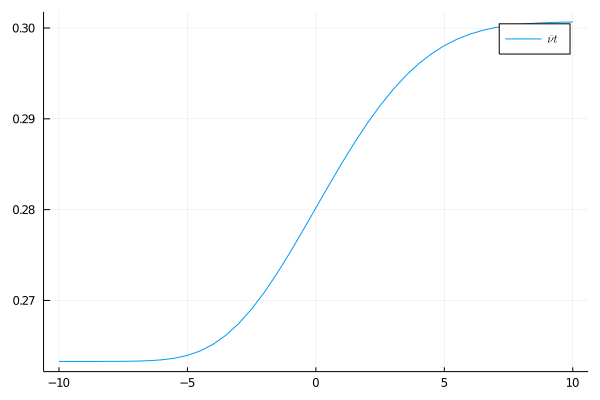

In [8]:
@everywhere begin
    semiconductor = Conduction.Semiconductor(
    1.38 * 10^-23, # Boltzman constant (J.K^-1)
    1.6*10^-19, # Electron's charge (C)
    10^7, # decay constant of the assumed hydrogen-like localized state wave functions (cm^-1)
    0.1 * 1.6*10^-19, # Mode effect of the phonons (J)
    2.1 * 10^18, # intrinsic semiconductor's density (cm^-3)
    2.1 * 10^18, # Doping states' density (cm^-3)
    0.1 * 1.6 * 10^-19, # Energy to a vacant target site (J)
    -2*10^3, # Field (V.cm^-1)
    10^13, # Base electron jump rate
    -10.0, # Fermi level (J)
    2.7, # Intrinsic semiconductor's gaussian width (J)
    2.7 # Doping states' gaussian width (J)
    );
end

criteria = pmap(x -> criteria_D(semiconductor, x, 300), range);
plot(range, criteria, label=L"\bar \nu t")

The criteria is below $1$ but not from much.

The same calculation was done with $F = -2 * 10^1$.

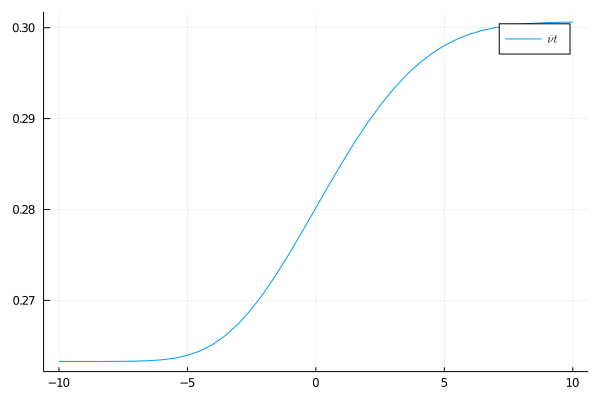

In [9]:
@everywhere begin
    semiconductor = Conduction.Semiconductor(
    1.38 * 10^-23, # Boltzman constant (J.K^-1)
    1.6*10^-19, # Electron's charge (C)
    10^7, # decay constant of the assumed hydrogen-like localized state wave functions (cm^-1)
    0.1 * 1.6*10^-19, # Mode effect of the phonons (J)
    2.1 * 10^18, # intrinsic semiconductor's density (cm^-3)
    2.1 * 10^18, # Doping states' density (cm^-3)
    0.1 * 1.6 * 10^-19, # Energy to a vacant target site (J)
    -2*10^1, # Field (V.cm^-1)
    10^13, # Base electron jump rate
    -10.0, # Fermi level (J)
    2.7, # Intrinsic semiconductor's gaussian width (J)
    2.7 # Doping states' gaussian width (J)
    );
end

criteria = pmap(x -> criteria_D(semiconductor, x, 300), range);
plot(range, criteria, label=L"\bar \nu t")

The result seems to be the same.

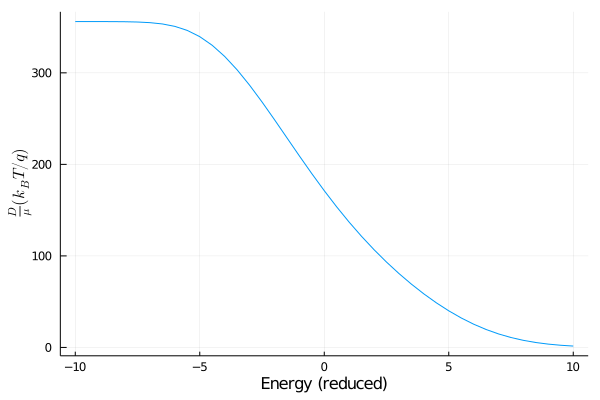

In [10]:
res = pmap(x -> einsteinRelation(semiconductor, x, 300.), range);
plot(range, res * semiconductor.k * 300 / semiconductor.q,
xlabel="Energy (reduced)", ylabel=L"\dfrac{D}{\mu} (k_B T / q)", label="")

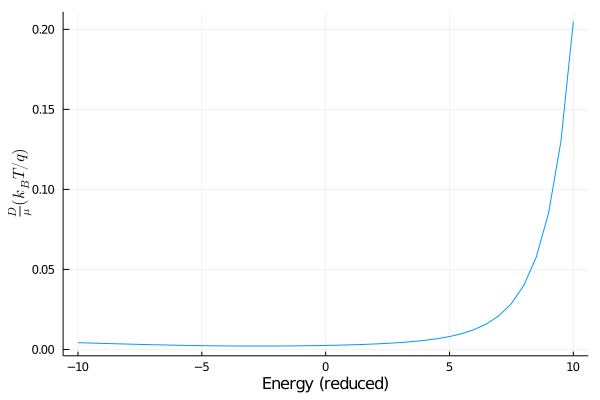

In [11]:
res_no_t = pmap(x -> einsteinRelation_no_t(semiconductor, x, 300.), range);
plot(range, res_no_t * semiconductor.k * 300 / semiconductor.q,
xlabel="Energy (reduced)", ylabel=L"\dfrac{D}{\mu} (k_B T / q)", label="")

Here again, it seems that the einstein ratio with t is too high compared to the one without t.